In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions
import gensim
import random
po.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None

## Patient pathway

In [2]:
#this was made from the cancerdata_EDA.ipynb
full_patient_pathways = pd.read_pickle('full_patient_pathways.pkl')

print("shape of patient_pathways ",full_patient_pathways.shape)
display(full_patient_pathways.head())

shape of patient_pathways  (777581, 111)


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID_y,MERGED_REGIMEN_ID_y,DRUG_GROUP_CORRECT
15,10001198,10001198,2015-01-16,C443,C44,8090,3,NaN,NaN,NaN,...,EOI,55.0,721,1.0,2015-09-02,STEROID,10001198,10002225,10003952,STEROID
18,10335837,10001198,2015-01-16,C444,D46,8090,1,NaN,NaN,NaN,...,EOI,55.0,721,1.0,2015-09-02,STEROID,10001198,10002225,10003952,STEROID
16,10001198,10001198,2015-01-16,C443,C44,8090,3,NaN,NaN,NaN,...,EGT,600.0,NaN,1.0,2015-09-03,BENDAMUSTINE,10001198,10002225,10003952,BENDAMUSTINE
17,10001198,10001198,2015-01-16,C443,C44,8090,3,NaN,NaN,NaN,...,EQM,70.0,NaN,1.0,2015-09-03,CISPLATIN,10001198,10002225,10003952,CISPLATIN
19,10335837,10001198,2015-01-16,C444,D46,8090,1,NaN,NaN,NaN,...,EGT,600.0,NaN,1.0,2015-09-03,BENDAMUSTINE,10001198,10002225,10003952,BENDAMUSTINE


# Assigning events

In [4]:
#only use 3 character icd10 codes for simplicity
full_patient_pathways['PRIMARY_DIAGNOSIS'] = full_patient_pathways['PRIMARY_DIAGNOSIS'].apply(lambda x: x[0:3])

The following cell treats a diagnosis,regimen taken and drug taken as an individual event. These can be obtained from full_patient_pathways by getting each column of those events and a column that has the dates of those events. We can stack all events which will get a sequence of events(as rows) per patient.

In [5]:
dates = ['DIAGNOSISDATEBEST','START_DATE_OF_REGIMEN','ADMINISTRATION_DATE',
        'DATE_OF_FINAL_TREATMENT','DATE_OF_FINAL_TREATMENT','DATE_OF_FINAL_TREATMENT','DATE_OF_FINAL_TREATMENT']
event_types = ['PRIMARY_DIAGNOSIS','BENCHMARK_GROUP','DRUG_GROUP_CORRECT',
              'REGIMEN_MOD_DOSE_REDUCTION','REGIMEN_MOD_TIME_DELAY','REGIMEN_MOD_STOPPED_EARLY','REGIMEN_OUTCOME_SUMMARY']

sequences_df = pd.DataFrame()

for date, event_type in zip(dates,event_types):
    
    #get the events and event dates,
    #we must drop duplicates as some are replicated due to the merging
    #in cancerdata_EDA
    df = full_patient_pathways[['PATIENTID', date, event_type]].drop_duplicates()
    df = df.rename(index=str, columns={date:'date', event_type:'event'})
    
    #any event with 'N either means 
    #NO(nothing happend) or not known(for outcome summary)'
    df = df[df['event'] != 'N']
    
    df['event_type'] = event_type
    
    #some drug group values are the same as there regimen values
    df['event'] = df['event_type'] + " " + df['event']
    
    #get rid of NaN events
    df = df[df['event'].notnull()]
    
    #stack the events and event dates
    sequences_df = pd.concat([sequences_df,df])
    
sequences_df = sequences_df.sort_values(by = ['PATIENTID','date'])
    
sequences_df.head(10)

,PATIENTID,date,event,event_type
15,10001198,2015-01-16 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS
15,10001198,2015-02-27,BENCHMARK_GROUP FLUOROURACIL,BENCHMARK_GROUP
15,10001198,2015-09-02,DRUG_GROUP_CORRECT STEROID,DRUG_GROUP_CORRECT
16,10001198,2015-09-03,DRUG_GROUP_CORRECT BENDAMUSTINE,DRUG_GROUP_CORRECT
17,10001198,2015-09-03,DRUG_GROUP_CORRECT CISPLATIN,DRUG_GROUP_CORRECT
21,10001976,2014-02-25 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS
24,10001976,2014-10-17 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS
21,10001976,2014-11-16,BENCHMARK_GROUP CISPLATIN + GEMCITABINE,BENCHMARK_GROUP
21,10001976,2015-01-18,DRUG_GROUP_CORRECT TRIAL,DRUG_GROUP_CORRECT
22,10001976,2015-01-18,DRUG_GROUP_CORRECT STEROID,DRUG_GROUP_CORRECT


Convert dates to number of days passed since first event

In [6]:
df_dates = sequences_df[['PATIENTID','date']]
df_dates['date'] = pd.to_datetime(df_dates['date'])
df_start_dates = df_dates.groupby('PATIENTID').first().reset_index().rename(columns={'date':'start date'})
df_dates = pd.merge(df_dates,df_start_dates,how='left')
df_dates['days'] = df_dates['date']-df_dates['start date']
sequences_df['days'] = [d.days for d in df_dates['days']]

sequences_df.head(10)

,PATIENTID,date,event,event_type,days
15,10001198,2015-01-16 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS,0.0
15,10001198,2015-02-27,BENCHMARK_GROUP FLUOROURACIL,BENCHMARK_GROUP,42.0
15,10001198,2015-09-02,DRUG_GROUP_CORRECT STEROID,DRUG_GROUP_CORRECT,229.0
16,10001198,2015-09-03,DRUG_GROUP_CORRECT BENDAMUSTINE,DRUG_GROUP_CORRECT,230.0
17,10001198,2015-09-03,DRUG_GROUP_CORRECT CISPLATIN,DRUG_GROUP_CORRECT,230.0
21,10001976,2014-02-25 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS,0.0
24,10001976,2014-10-17 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS,234.0
21,10001976,2014-11-16,BENCHMARK_GROUP CISPLATIN + GEMCITABINE,BENCHMARK_GROUP,264.0
21,10001976,2015-01-18,DRUG_GROUP_CORRECT TRIAL,DRUG_GROUP_CORRECT,327.0
22,10001976,2015-01-18,DRUG_GROUP_CORRECT STEROID,DRUG_GROUP_CORRECT,327.0


In [7]:
#add diagnosis of patient as a column for color coding later
cancers_df = full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
sequences_df = pd.merge(sequences_df,cancers_df,how='left',on='PATIENTID')

Assign each unique event a label

In [8]:
unique_events_df = sequences_df[['event']].drop_duplicates().reset_index(drop=True)
unique_events_df['event_label'] = unique_events_df.index.astype(str)
unique_events_df.head()

,event,event_label
0,PRIMARY_DIAGNOSIS C44,0
1,BENCHMARK_GROUP FLUOROURACIL,1
2,DRUG_GROUP_CORRECT STEROID,2
3,DRUG_GROUP_CORRECT BENDAMUSTINE,3
4,DRUG_GROUP_CORRECT CISPLATIN,4


Add the event_label into the sequences_df

In [9]:
sequences_df = pd.merge(sequences_df, unique_events_df, how='left',on='event')
sequences_df.head(10)

,PATIENTID,date,event,event_type,days,PRIMARY_DIAGNOSIS,event_label
0,10001198,2015-01-16 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS,0.0,C44,0
1,10001198,2015-02-27,BENCHMARK_GROUP FLUOROURACIL,BENCHMARK_GROUP,42.0,C44,1
2,10001198,2015-09-02,DRUG_GROUP_CORRECT STEROID,DRUG_GROUP_CORRECT,229.0,C44,2
3,10001198,2015-09-03,DRUG_GROUP_CORRECT BENDAMUSTINE,DRUG_GROUP_CORRECT,230.0,C44,3
4,10001198,2015-09-03,DRUG_GROUP_CORRECT CISPLATIN,DRUG_GROUP_CORRECT,230.0,C44,4
5,10001976,2014-02-25 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS,0.0,C44,0
6,10001976,2014-10-17 00:00:00,PRIMARY_DIAGNOSIS C44,PRIMARY_DIAGNOSIS,234.0,C44,0
7,10001976,2014-11-16,BENCHMARK_GROUP CISPLATIN + GEMCITABINE,BENCHMARK_GROUP,264.0,C44,5
8,10001976,2015-01-18,DRUG_GROUP_CORRECT TRIAL,DRUG_GROUP_CORRECT,327.0,C44,6
9,10001976,2015-01-18,DRUG_GROUP_CORRECT STEROID,DRUG_GROUP_CORRECT,327.0,C44,2


In [10]:
unique_events_df.shape

(915, 2)

There are 915 unique events

## word2vec

Convert each unique event into a vector of features.

These features are learned with a neural net using gensim, but we must give as input sequences of events to find out the features of these events.

In [11]:
#Create a series which has the sequence of events for a given patient
sequences = sequences_df.groupby(['PATIENTID'])['event_label'].agg(lambda x: list(x))

In [12]:
sequences.shape

(68687,)

In [13]:
#examples of sequences of events
print(list(sequences)[9])
print(list(sequences)[3])

['37', '5', '10', '7', '3', '10', '38', '26', '39', '10', '10', '40', '41', '42', '2', '43', '44', '8']
['0', '11', '3', '10', '12', '10', '12']


In [14]:
#converts all events to vectors
model = gensim.models.Word2Vec(sentences = list(sequences),
                               size=100, 
                               window=120, 
                               workers =4, 
                               min_count=1,
                               iter = 10)

In [15]:
model['21'] #the vector for event 21

/Users/jeremyocampo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



array([-0.38959038,  0.7611782 ,  0.4329858 ,  1.3418779 ,  1.3975186 ,
       -2.8188493 , -0.6389815 ,  0.02366994, -0.16513711, -1.3654699 ,
        0.7646393 , -0.72788835,  0.38093865,  0.6922886 , -0.7647813 ,
       -1.32811   , -2.5295837 ,  2.2456343 ,  2.0513475 ,  1.3802117 ,
        1.1176896 , -0.5204425 ,  0.14679925,  0.15278307, -0.70540494,
        0.31188217, -1.5519595 , -0.21368662,  0.7228164 , -1.547081  ,
       -0.10650918, -0.04939498, -0.79372627,  0.3328169 ,  0.01065336,
       -0.91101485,  0.5565999 , -0.9010362 ,  0.15820839, -0.13612075,
       -0.21074049,  0.65570945, -0.25078958, -0.66256005,  0.8543498 ,
       -0.10870647, -0.92308635,  0.20779225, -0.07340159, -0.25006983,
       -0.23314041,  0.6047989 ,  0.31353283,  1.1506584 , -0.6722412 ,
        0.30619338, -0.04433652, -0.13729353,  0.8593482 ,  0.8323433 ,
        1.1694728 , -0.66985214,  0.03006973,  0.4365556 , -0.61385936,
        0.40144172,  0.41823527, -0.8561353 ,  0.07718822,  0.01

In [16]:
len(model.wv.vocab)

915

## Dimension reduction

Use PCA to reduce the size of the vectors and project onto an optimal 3D dimension where clusters of individual events may be identified

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [18]:
X = model[model.wv.vocab]
#pca = PCA(n_components=3)
#tsne = TSNE(n_components=3)
um = umap.UMAP(n_components=2)
result = um.fit_transform(X)

/Users/jeremyocampo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



TSNE tries to preserve the same proportions of distances between points, in the 100D spae and the 3D space.

Get 2D co-ordinates of each event

In [19]:
event_vector_df = pd.DataFrame({'event_label':list(model.wv.vocab.keys()),
                                'x':result[:,0],
                                'y':result[:,1]})
label_type_df = sequences_df[['event_type','event_label']].drop_duplicates()
event_vector_df = pd.merge(event_vector_df,label_type_df,on='event_label', how='left')

print(event_vector_df.shape)
event_vector_df.head()

(915, 4)


,event_label,x,y,event_type
0,0,3.250909,4.958661,PRIMARY_DIAGNOSIS
1,1,-2.886019,6.840144,BENCHMARK_GROUP
2,2,0.701591,3.367953,DRUG_GROUP_CORRECT
3,3,4.652643,0.441878,DRUG_GROUP_CORRECT
4,4,-2.004929,3.085421,DRUG_GROUP_CORRECT


In [20]:
#plot the events, colour coded by event_type

data=[]
color = np.random.seed(seed=20)
#desc = [d for d in descriptions.get_descriptions(uniqcancer, 'icd')]
for event_type in event_types:
    color=np.random.randint(255, size=(1, 3))[0]
    x = event_vector_df[event_vector_df['event_type']==event_type]['x']
    y = event_vector_df[event_vector_df['event_type']==event_type]['y']
    
    trace = go.Scatter( x = x,
                        y = y,
                        mode = 'markers',
                        name = event_type,
                        marker = dict(size = 3,
                                      color = 'rgb({}, {}, {})'.format(*color)) )
    data.append(trace)

layout = dict(title = 'Visualisation of events',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

### patient pathway visualization

In [21]:
#create a map that gets you from the event to its 2D PCA vector
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X)
map2D = {k:vector for k,vector in zip(model.wv.vocab.keys(),pca_vectors)}

Add diagnosis of patient to colour code by cancer

In [22]:
sequence_cancer_df = pd.DataFrame(sequences).reset_index().rename(index=str,columns={'event_label':'sequence'})
cancers_df = full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
sequence_cancer_df = pd.merge(sequence_cancer_df,cancers_df,how='left',on='PATIENTID')
sequence_cancer_df.head()

,PATIENTID,sequence,PRIMARY_DIAGNOSIS
0,10001198,"[0, 1, 2, 3, 4]",C44
1,10001976,"[0, 0, 5, 6, 2, 7, 8]",C44
2,10002361,"[0, 1, 9, 10]",C44
3,10002568,"[0, 11, 3, 10, 12, 10, 12]",C44
4,10002929,"[13, 10, 14, 0, 15, 4, 16, 2, 17, 18, 0, 19, 10]",C44


Now add up the vectors of events in a sequence to get the pathway and plot it

In [23]:
data=[]

#color code by cancer type

top5cancers = sequence_cancer_df['PRIMARY_DIAGNOSIS'].value_counts().keys()[:5]

np.random.seed(seed=20)
for c in top5cancers:

    color = np.random.randint(255, size=(1, 3))[0]
    
    c_sequences = sequence_cancer_df[sequence_cancer_df['PRIMARY_DIAGNOSIS'] == c]
    c_sequences100 = random.choices(list(c_sequences['sequence']),k=100)
    
    legend = True
    for s in c_sequences100:
        event_vectors = np.array([list(map2D[e]) for e in s])
        pathway_coordinates = np.cumsum(event_vectors, axis=0)

    
        trace = go.Scatter( x = pathway_coordinates[:,0],
                            y = pathway_coordinates[:,1],
                            mode = 'lines',
                            name = c,
                            legendgroup = c,
                            line=dict(width=1,
                                      color='rgb({}, {}, {})'.format(*color)), 
                            showlegend = legend)
        legend = False
        data.append(trace)

layout = dict(title = 'Visualisation of pathways',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

what the ICD10 codes mean:

In [24]:
desc5 = descriptions.get_descriptions(top5cancers, 'icd')
for c,d in zip(top5cancers,desc5):
    print(c,d)

C50 MALIGNANT NEOPLASM OF BREAST
C34 MALIGNANT NEOPLASM OF LUNG
C18 MALIGNANT NEOPLASM OF COLON
C61 MALIGNANT NEOPLASM OF PROSTATE
C83 NON-HODGKIN"S LYMPHOMA


The pathways look like they've clustered well according to the type of cancer, meaning similar cancers have similar drugs/regimens, this isn't really usefull information, so it's better to try and use a clustering algorithm on a specific cancer

### Clustering of single cancer pathways

Start of by looking at c50 (breast)

In [46]:
single_cancer = 'C50' #3char
single_cancer_df = sequence_cancer_df[sequence_cancer_df['PRIMARY_DIAGNOSIS'] == single_cancer]
single_cancer_sequences = single_cancer_df['sequence']
single_cancer_df.head()

,PATIENTID,sequence,PRIMARY_DIAGNOSIS
41,10073021,"[89, 90, 22, 91, 22, 8, 2, 52, 92, 10, 28]",C50
59,10120084,"[67, 9, 10, 89]",C50
64,10137351,"[89, 21, 10, 2, 10]",C50
75,10153352,"[89, 129, 9, 10, 10, 52, 10, 32]",C50
77,10163033,"[89, 126, 7, 129, 7, 10, 68, 17, 26, 2, 42, 13...",C50


[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) converts a collection of raw documents to a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features.

In the patient pathway case, given a sequence, the TF-IDF of an event in that sequence would be a number between 0 to 1.
This number will:
* increase if that event is frequent in that sequence
* decrease if that event is frequent in all sequences

Each sequence will have a vector where the elements are the TF-IDF values of the events in that sequence. We would like to cluster these vectors to represent the clustering of the pathways.

The downside to using this is that this vector does not have information on the order of events.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

print("len(single_cancer_sequences):", len(single_cancer_sequences))
documents = [' '.join(s) for s in single_cancer_sequences]

vectorizer = TfidfVectorizer(max_df=1000000)
X = vectorizer.fit_transform(documents)
print("X.shape: ",X.shape)

kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1).fit(X=X)
lab = kmeans.labels_
print("lab.shape: ",lab.shape)

len(single_cancer_sequences): 18661
X.shape:  (18661, 309)
lab.shape:  (18661,)


Add cluster labels

In [48]:
single_cancer_df['cluster'] = lab
single_cancer_df.head()

,PATIENTID,sequence,PRIMARY_DIAGNOSIS,cluster
41,10073021,"[89, 90, 22, 91, 22, 8, 2, 52, 92, 10, 28]",C50,3
59,10120084,"[67, 9, 10, 89]",C50,3
64,10137351,"[89, 21, 10, 2, 10]",C50,3
75,10153352,"[89, 129, 9, 10, 10, 52, 10, 32]",C50,3
77,10163033,"[89, 126, 7, 129, 7, 10, 68, 17, 26, 2, 42, 13...",C50,3


Use Word2vec to visualize these clusters

In [49]:
single_model = gensim.models.Word2Vec(sentences = list(single_cancer_df['sequence']), 
                                      size=100, 
                                      window=120, 
                                      workers =4, 
                                      min_count=1)
#create a map that gets you from the event to its 3D PCA vector
event_vectors = single_model[single_model.wv.vocab]
pca = PCA(n_components=3)
pca_vectors = pca.fit_transform(event_vectors)
map3D = {k:vector for k,vector in zip(single_model.wv.vocab.keys(),pca_vectors)}

/Users/jeremyocampo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [50]:
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X.toarray())
map3D = {k:vector for k,vector in zip(single_model.wv.vocab.keys(),pca_vectors)}

In [51]:
single_cancer_df['x'] = pca_vectors[:,0]
single_cancer_df['y'] = pca_vectors[:,1]
single_cancer_df.head()

,PATIENTID,sequence,PRIMARY_DIAGNOSIS,cluster,x,y
41,10073021,"[89, 90, 22, 91, 22, 8, 2, 52, 92, 10, 28]",C50,3,0.065053,0.026478
59,10120084,"[67, 9, 10, 89]",C50,3,0.058995,0.012807
64,10137351,"[89, 21, 10, 2, 10]",C50,3,-0.066611,-0.030853
75,10153352,"[89, 129, 9, 10, 10, 52, 10, 32]",C50,3,0.021417,-0.008740
77,10163033,"[89, 126, 7, 129, 7, 10, 68, 17, 26, 2, 42, 13...",C50,3,0.047566,0.022555


Plotting

In [52]:
data=[]

#color code by label

clusters = single_cancer_df['cluster'].unique()

np.random.seed(seed=20)
for c in clusters:

    color = np.random.randint(255, size=(1, 3))[0]
    
    c_sequences = single_cancer_df[single_cancer_df['cluster'] == c]
    c_sequences100 = random.choices(list(c_sequences['sequence']),k=100)
    
    legend = True
    for s in c_sequences100:
        event_vectors = np.array([list(map3D[e]) for e in s])
        pathway_coordinates = np.cumsum(event_vectors, axis=0)

    
        trace = go.Scattergl(   x = pathway_coordinates[:,0],
                                y = pathway_coordinates[:,1],
                                mode = 'lines',
                                name = str(c),
                                legendgroup= str(c),
                                line=dict(width=3,color='rgb({}, {}, {})'.format(*color)), 
                                showlegend = legend)
        legend = False
        data.append(trace)

layout = dict(title = 'Clustering '+single_cancer+' pathways',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

An individual line on this plot represents the pathway of an individual patient. They are colour coded by the cluster they belong to.

The clustering seems to have done well, but to find meaning in these clusters we have to look at the events that happen there.

histogram of clusters:

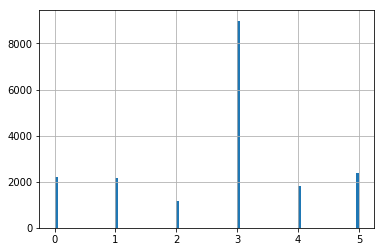

In [53]:
pd.Series(lab).hist(bins = 100)

The top 5 regimens and drugs in each cluster:

In [54]:
#get sequences_df of the single cancer
df_single_cancer_seq = sequences_df[sequences_df['PRIMARY_DIAGNOSIS']==single_cancer]

#add the cluster labels into the df_single_cancer_seq
df_single_cancer_seq = pd.merge(df_single_cancer_seq,single_cancer_df[['PATIENTID','cluster']], how = 'left')

#remove the event type in the 'event' column
df_single_cancer_seq['event'] = [e[len(et)+1:] for e,et in
                                zip(df_single_cancer_seq['event'],df_single_cancer_seq['event_type'])]

Given a cluster, what are the top drugs/regimens/outcome in that cluster, and how many days did it take until that event happened?

In [55]:
cluster = 1
top = 5

print("Cluster",cluster,"\n")
print("top",top,"drugs, regimens and outcome, showing how many days from the first event that they were administered")
for event_type in ['DRUG_GROUP_CORRECT','BENCHMARK_GROUP','REGIMEN_OUTCOME_SUMMARY']:
    
    df_cluster_i = df_single_cancer_seq.loc[(df_single_cancer_seq['cluster'] == cluster)
                                  & (df_single_cancer_seq['event_type'] == event_type)]
    top5 = df_cluster_i['event'].value_counts()[:top]
    df_top5 = df_cluster_i[df_cluster_i['event'].isin(top5.keys())]
    mean_days = df_top5.groupby('event')['days'].mean()
    df_freq = pd.DataFrame(top5).reset_index().rename(columns={'index':event_type,'event':"frequency"})
    df_days = pd.DataFrame(mean_days).reset_index().rename(columns={'event':event_type,'days':'mean days'})
    df_freq_days = pd.merge(df_freq,df_days)

    display(df_freq_days)

Cluster 1 

top 5 drugs, regimens and outcome, showing how many days from the first event that they were administered


,DRUG_GROUP_CORRECT,frequency,mean days
0,TRASTUZUMAB,3928,245.422352
1,NOT CHEMO,2914,281.957447
2,CYCLOPHOSPHAMIDE,1794,278.131550
3,EPIRUBICIN,1717,277.558532
4,STEROID,1344,282.130208


,BENCHMARK_GROUP,frequency,mean days
0,HORMONES,3295,202.223976
1,FEC,9,464.111111
2,EC + DOCETAXEL,9,142.222222
3,CYCLOPHOSPHAMIDE + DOCETAXEL,7,412.142857
4,DOCETAXEL,6,617.500000


,REGIMEN_OUTCOME_SUMMARY,frequency,mean days
0,0,10,202.666667
1,2,3,598.666667
2,1,2,305.000000
3,3,1,NaN
4,7,1,NaN


### Using LSTM as an autoencoder (unfinished)

This turns a sequence into a small dimensional vector(an embedding) which would be the same length for all sequences. Hopefully the sequences can be clustered using their vectors.

In [44]:
model10D = gensim.models.Word2Vec(sentences = list(single_cancer_df['sequence']), 
                                      size=10, 
                                      window=120, 
                                      workers =4, 
                                      min_count=1)
sequence_vectors = single_cancer_sequences.apply(lambda x: np.array([list(model10D[event]) for event in x]))

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [41]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

In [42]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
import time

In [55]:
a = time.time()

samples = 4
# define input sequence
def train_generator():
    while True:
        for s in sequence_vectors[0:samples]:
            s = s.reshape((1, s.shape[0], s.shape[1]))
            yield s,s

train_gen = train_generator()

#define model
model = Sequential()
model.add(LSTM(10, activation='linear', input_shape=(None,10), return_sequences=True)) #encoder
model.add(LSTM(10, activation='linear', return_sequences=True)) #decoder
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(train_gen, steps_per_epoch=samples, epochs=500, verbose=0)

# let the output be the sequence outputted
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

print("time (s): ", time.time() - a)

time (s):  136.23795914649963


In [56]:
# get output sequence which should be similar to input
sequence = np.expand_dims(list(sequence_vectors[0:samples])[0], axis=0)
yhat = model.predict(sequence)

In [57]:
print(yhat)
print(list(sequence_vectors[0:samples])[0])
print(np.abs(sequence-yhat).mean())

[[[ 0.00341894  0.11278173  0.06965403  0.13342285  0.07932175
   -0.05646963  0.0240285  -0.05499431 -0.02793959 -0.01310594]
  [ 0.01200029  0.22856753  0.14613861  0.2800966   0.1555381
   -0.10668864  0.05834638 -0.11713934 -0.0538835  -0.03478231]
  [ 0.03128882  0.9433262   0.9099708   1.3221424   0.87757015
   -0.4090665   0.4889554  -0.5281448  -0.32611087 -0.24906299]
  [ 0.02859633  0.8186311   0.69590104  1.0616459   0.6281229
   -0.3274622   0.35610053 -0.35005748 -0.26536882 -0.22289923]
  [ 0.03407487  0.841836    0.5874921   0.9724501   0.53826994
   -0.3441053   0.28513777 -0.3029774  -0.20377235 -0.20766373]
  [ 0.04128768  0.37244397  0.19916354  0.37007794  0.19262719
   -0.16602397  0.05513851 -0.15363555 -0.02423639 -0.08217492]
  [ 0.07128605  0.92321396  0.82417554  1.2885977   0.79399407
   -0.40125495  0.43744075 -0.5213132  -0.32973036 -0.21780689]
  [ 0.06599686  0.8862148   1.0434114   1.4341512   0.9883119
   -0.3923057   0.53708625 -0.56823367 -0.45638657 